# GRAVITATIONAL WAVE DETECTION BIAS
Here we have simulated data of gravitational wave signals produced by black-hole binaries. It is simulated also the detection of the signal by the LIGO experiments, so every event has its Signal to Noise Ratio (SNR). We consider an event 'detectable' if the SNR is greater than 12. So basically we have some events, characterized by some features, labelled 'detectable' or 'not detectable'. We want to build a binary classifier capable of reproducing the selection bias of the detector. We begin working on a reduced dataset of 10000 sample with all the feature space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from corner import corner
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from astroML.classification import GMMBayes
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
dataset = h5py.File("sample_2e7_design_precessing_higherordermodes_3detectors.h5", 'r')

In [3]:
print(list(dataset.keys()))

['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']


In [4]:
n_sample = 10000
y = np.array(dataset['det'])[:n_sample]
X = np.transpose(np.array([(dataset['mtot'])[:n_sample], (dataset['q'])[:n_sample], (dataset['ra'])[:n_sample],\
                           (dataset['dec'])[:n_sample], (dataset['iota'])[:n_sample], (dataset['z'])[:n_sample], \
                           (dataset['chi1x'])[:n_sample], (dataset['chi1y'])[:n_sample], (dataset['chi1z'])[:n_sample], \
                           (dataset['chi2x'])[:n_sample], (dataset['chi2y'])[:n_sample], (dataset['chi2z'])[:n_sample], \
                           (dataset['psi'])[:n_sample]]))

We proceed in classifying the dataset. We'll try two classifiers: the Random Forest and the Adaptive Boosting.
## Random Forest
We begin cross-validating the depth of the decision trees to get the model with the best trade between accuracy and complexity:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
depth_max = 20
acc_train = np.zeros(depth_max)
acc_test = np.zeros(depth_max)
for i in range(1, depth_max+1):
    clf = RandomForestClassifier(n_estimators=10, max_depth=i, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)
    acc_train[i-1] = accuracy_score(y_train, y_train_pred)
    acc_test[i-1] = accuracy_score(y_test, y_test_pred)

Text(0, 0.5, 'Accuracy')

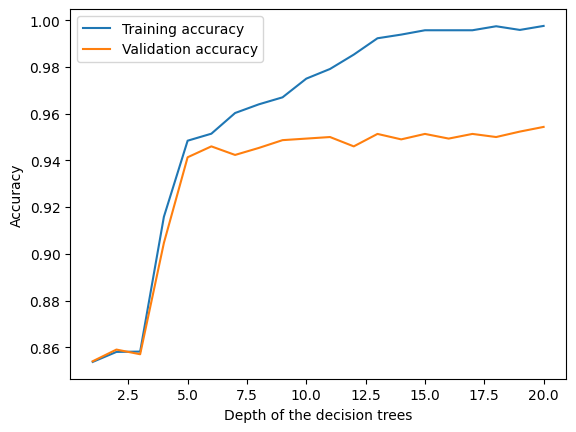

In [6]:
plt.plot(range(1, depth_max+1), acc_train, label = "Training accuracy")
plt.plot(range(1, depth_max+1), acc_test, label = "Validation accuracy")
plt.legend()
plt.xlabel("Depth of the decision trees")
plt.ylabel("Accuracy")

We can choose the best model, given by the depth where the plateau of the validation accuracy begins:

In [7]:
depth_best_RF = 6
print("Best accuracy: {:.3f}%; obtained with a depth of {}".format(100*acc_test[depth_best_RF], depth_best_RF + 1))

Best accuracy: 94.233%; obtained with a depth of 7


## Adaptive Boosting
We now do the same things we have just done but for the Adaptive Boosting:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
depth_max = 15
acc_train = np.zeros(depth_max)
acc_test = np.zeros(depth_max)
for i in range(1, depth_max+1):
    clf = GradientBoostingClassifier(n_estimators=10, max_depth=i)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)
    acc_train[i-1] = accuracy_score(y_train, y_train_pred)
    acc_test[i-1] = accuracy_score(y_test, y_test_pred)

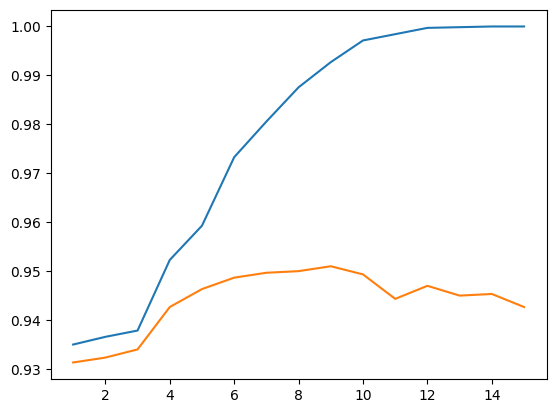

In [9]:
plt.plot(range(1, depth_max+1), acc_train)
plt.plot(range(1, depth_max+1), acc_test)

Again we choose the best model, given by the depth where the plateau of the validation accuracy begins:

In [10]:
depth_best_B = 5
print("Best accuracy: {:.3f}%; obtained with a depth of {}".format(acc_test[depth_best_B]*100, depth_best_B + 1))

Best accuracy: 94.867%; obtained with a depth of 6


## Comparison
We can compare them using the ROC curve:

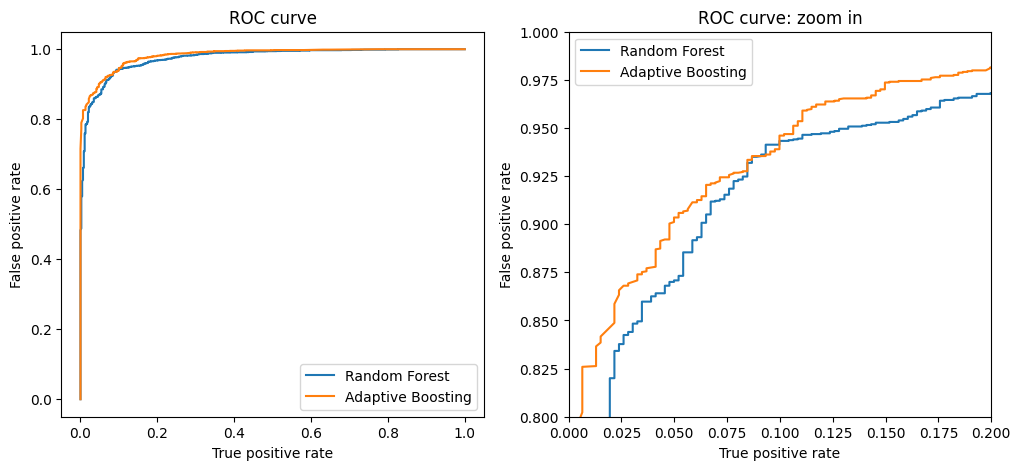

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
plt.figure(figsize=(12, 5))
clf = RandomForestClassifier(n_estimators=10, max_depth=depth_best_RF, n_jobs=-1)
clf.fit(X_train, y_train)
y_test_prob = clf.predict_proba(X_test)[:, 0]
fps, tps, _ = roc_curve(y_test, y_test_prob)
plt.subplot(1, 2, 1)
plt.plot(tps, fps, label = "Random Forest")
plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title("ROC curve")
plt.subplot(1, 2, 2)
plt.plot(tps, fps, label = "Random Forest")
plt.xlim(0.0, 0.2)
plt.ylim(0.8, 1.0)
plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title("ROC curve: zoom in")

clf = GradientBoostingClassifier(n_estimators=10, max_depth=depth_best_B)
clf.fit(X_train, y_train)
y_test_prob = clf.predict_proba(X_test)[:, 0]
fps, tps, _ = roc_curve(y_test, y_test_prob)
plt.subplot(1, 2, 1)
plt.plot(tps, fps, label = "Adaptive Boosting")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(tps, fps, label = "Adaptive Boosting")
plt.xlim(0.0, 0.2)
plt.ylim(0.8, 1.0)
plt.legend()

On this reduced dataset, the Adaptive Boosting algorithm seems to be slightly better both in accuracy and in the ROC graph.
## Trying to reduce the dimensions
We want to see if with dimensional reduction we get a better performance. We'll use PCA from the full feature space, and we study its performance looking at the explained variance.

In [12]:
n_sample = 10000
y = np.array(dataset['det'])[:n_sample]
X = np.transpose(np.array([(dataset['mtot'])[:n_sample], (dataset['q'])[:n_sample], (dataset['ra'])[:n_sample],\
                           (dataset['dec'])[:n_sample], (dataset['iota'])[:n_sample], (dataset['z'])[:n_sample], \
                           (dataset['chi1x'])[:n_sample], (dataset['chi1y'])[:n_sample], (dataset['chi1z'])[:n_sample], \
                           (dataset['chi2x'])[:n_sample], (dataset['chi2y'])[:n_sample], (dataset['chi2z'])[:n_sample], \
                           (dataset['psi'])[:n_sample]]))

In [13]:
sc = StandardScaler()
sc.fit(X)
X_sc = sc.transform(X)

In [14]:
pca = PCA(n_components=13)
pca.fit(X_sc)
projected = pca.transform(X_sc)

Text(0.5, 1.0, 'Cumulative variance explained by component')

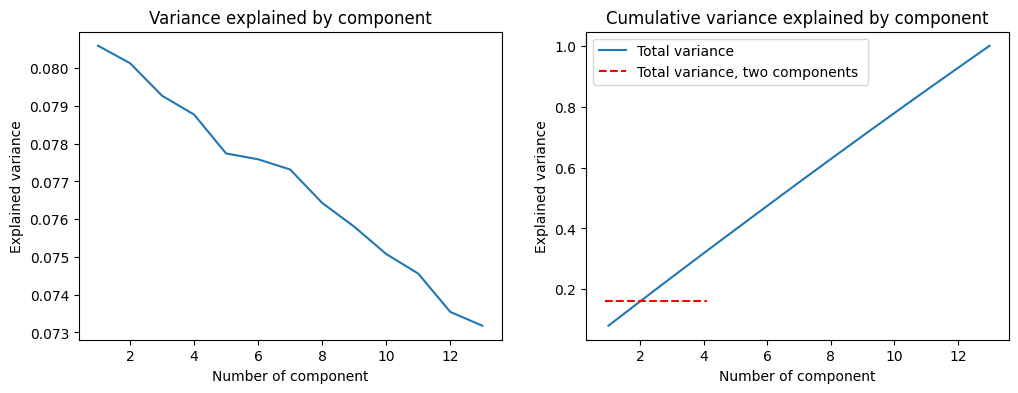

In [15]:
exp_var = pca.explained_variance_ratio_
cum_var = np.cumsum(exp_var)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(exp_var) + 1), exp_var)
plt.xlabel("Number of component")
plt.ylabel("Explained variance")
plt.title("Variance explained by component")

plt.subplot(1, 2, 2)
plt.plot(range(1, len(exp_var) + 1), cum_var, label = "Total variance")
xgrid = np.linspace(0.9, 4.1, 1000)
ygrid = np.full(1000, cum_var[1])
plt.plot(xgrid, ygrid, ls = '--', c = 'red', label="Total variance, two components ")
plt.legend()
plt.xlabel("Number of component")
plt.ylabel("Explained variance")
plt.title("Cumulative variance explained by component")

We can see from the plot on the right that the explained variance grows linearly with the number of components kept. To reach a total explained variance of at least $80$% we need about 10 components of the 13 available. Basically, in this case PCA is useless.

Maybe, using a non-linear dimensionality reduction algorithm can do better in this case.
## Final classifier
Now that we understood that it is better to keep the full feature space, we can train the best algorithm on the full dataset: the Adaptive Boosting. Then we cas see the accuracy.

In [16]:
n_sample = 20000000
y = np.array(dataset['det'])[:n_sample]
X = np.transpose(np.array([(dataset['mtot'])[:n_sample], (dataset['q'])[:n_sample], (dataset['ra'])[:n_sample],\
                           (dataset['dec'])[:n_sample], (dataset['iota'])[:n_sample], (dataset['z'])[:n_sample], \
                           (dataset['chi1x'])[:n_sample], (dataset['chi1y'])[:n_sample], (dataset['chi1z'])[:n_sample], \
                           (dataset['chi2x'])[:n_sample], (dataset['chi2y'])[:n_sample], (dataset['chi2z'])[:n_sample], \
                           (dataset['psi'])[:n_sample]]))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
clf = GradientBoostingClassifier(n_estimators=10, max_depth=depth_best_B)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

In [18]:
print("Best accuracy: {:.3f}%; obtained with a depth of {}".format(accuracy_score(y_test, y_test_pred)*100, depth_best_B + 1))

Best accuracy: 95.126%; obtained with a depth of 6
